## Contents
-  [1.Importing Libraries](#1)
-  [2.Dataset Managament](#2)
    -  [2.1.Pytorch Dataset](#2.1)
    -  [2.2.Pytorch DataLoaders](#2.2)
-  [3.Creating a CNN-Siamese Model](#3)
-  [4.Training](#4)
-  [5.Plotting Graphs](#5)
    -  [5.1.Plotting Loss vs Epoch](#5.1)
    -  [5.2.Plotting Accuracy vs Epoch](#5.2)
-  [6.Loading and Testing](#6)
    -  [6.1.Reference Images](#6.1)
    -  [6.2.Target Images](#6.2)
    -  [6.3.Predictions](#6.3)

### 1.Importing Libraries <a class="anchor" id="1"></a>

In [1]:
import cv2
import os
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as T
from PIL import Image
from torch.utils.data import Dataset as Dataset
from facenet_pytorch import MTCNN, InceptionResnetV1
from torch.utils.data import DataLoader as DataLoader

torch.cuda.empty_cache()

sns.set_style("darkgrid")


### 2.Dataset Managament <a class="anchor" id="2"></a>

#### 1.Pytorch Datasets<a class="anchor" id="2.1"></a>

In [2]:
class olivetti_faces_dataset(Dataset):
    def __init__(self):
        path = 'data/train/'
        img = np.load(path+'olivetti_faces.npy') #First 10 same class
        self.transforms = T.Compose([T.ToTensor()])
        self.device = 'cuda'
        self.resnet = InceptionResnetV1(pretrained='vggface2').to(self.device).eval()
        self.data = []
        for i in range(40):
            self.data.append(img[i*10:i*10 + 10])
        
    def __len__(self):
        return 800
    
    def embedding(self,x):
        with torch.no_grad():
            x = cv2.merge((x,x,x))*255
            x = cv2.resize(x, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
            x = (x - 127.5) / 128.0
        return self.resnet(self.transforms(x).unsqueeze(0).to(self.device))
        
    def __getitem__(self,idx):
        img1 , img2 , label = None , None , None
        if idx%2 == 0: # same img
            label = 1
            n = random.randrange(0,40)
            img1 = self.data[n][random.randrange(0,10)]
            img2 = self.data[n][random.randrange(0,10)]
    
        
        else:
            label = 0
            n = random.randrange(0,40)
            img1 = self.data[n][random.randrange(0,10)]
            n = random.randrange(0,40)
            img2 = self.data[n][random.randrange(0,10)]

        
        img1_embedding = self.embedding(img1)
        img2_embedding = self.embedding(img2)
        return img1_embedding , img2_embedding , torch.FloatTensor([label]).to(self.device)
    


#### 2.Pytorch DataLoaders<a class="anchor" id="2.2"></a>

In [3]:
train_dataset = olivetti_faces_dataset()
train_dataloader = DataLoader(train_dataset,32)

### 3.Creating a CNN-Siamese Model <a class="anchor" id="3"></a>

In [4]:
class siamese_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(512,256)
        self.bn1 = nn.BatchNorm1d(256)
        self.out = nn.Linear(256,1)
    
    
    def hidden_forward(self,x):
        x = F.relu(self.l1(x))
        x =  self.bn1(x)
        return x       

    def forward(self,x1,x2):
        x = torch.abs(x1.view(-1,512)- x2.view(-1,512))
        return torch.sigmoid(self.out(self.hidden_forward(x)))
    
device = 'cuda'

model = siamese_model()
model.to(device)
criterion = nn.BCELoss() 
optimizer = optim.Adam(model.parameters(),lr = 0.001)

epoch = 50
loss_history = [[],[]]
accuracy_history = [[],[]]
train_n_minibatches = train_dataloader.__len__()

### 4.Training <a class="anchor" id="4"></a>

In [5]:
best_acc = 0
best_loss = 0

for e in range(epoch):
    model.train()
    for batch_idx , x in enumerate(train_dataloader):
        optimizer.zero_grad()
        x , y , z = x[0] , x[1] , x[2]
        y_pred = model(x,y)
        
        # Calculating Loss
        loss = criterion(y_pred,z)
        loss.backward()
        optimizer.step()
        loss_history[0].append(float(loss.detach()))
        
        #Calaculating Accuracy
        correct = 0
        y_pred = y_pred.cpu().detach().numpy().tolist()
        y = z.cpu().detach().numpy().tolist()
        for i,j in zip(y,y_pred):
            if round(j[0]) == int(i[0]):
                correct = correct + 1
        accuracy_history[0].append((correct/x.shape[0])*100)
    
    loss_history[1].append(sum(loss_history[0][-1:-train_n_minibatches-1:-1])/train_n_minibatches)
    accuracy_history[1].append(sum(accuracy_history[0][-1:-train_n_minibatches-1:-1])/train_n_minibatches)
    
    if best_acc < accuracy_history[1][-1]:
        best_acc = accuracy_history[1][-1]
        best_loss = loss_history[1][-1]
        
        torch.save(model.state_dict(),'saved_models/siamese_model')
        
    
    if (e+1)%1 == 0:
    #Log for e+1th epoch
        print(f'---------------------------------------EPOCH {e+1}-------------------------------------------')
        print(f'Loss for EPOCH {e+1}  TRAIN LOSS : {loss_history[1][-1]}',end = ' ')
        print(f'TRAIN ACCURACY : {accuracy_history[1][-1]}')
        print(f'---------------------------------------------------------------------------------------------')
        
print(f'\n After {epoch} epcohs ACCURACY : {best_acc}%  LOSS : {best_loss}')

---------------------------------------EPOCH 1-------------------------------------------
Loss for EPOCH 1  TRAIN LOSS : 0.1479623819887638 TRAIN ACCURACY : 94.875
---------------------------------------------------------------------------------------------
---------------------------------------EPOCH 2-------------------------------------------
Loss for EPOCH 2  TRAIN LOSS : 0.050242280289530754 TRAIN ACCURACY : 99.5
---------------------------------------------------------------------------------------------
---------------------------------------EPOCH 3-------------------------------------------
Loss for EPOCH 3  TRAIN LOSS : 0.10071084767580032 TRAIN ACCURACY : 98.25
---------------------------------------------------------------------------------------------
---------------------------------------EPOCH 4-------------------------------------------
Loss for EPOCH 4  TRAIN LOSS : 0.08296870224177838 TRAIN ACCURACY : 98.875
-------------------------------------------------------------

---------------------------------------EPOCH 33-------------------------------------------
Loss for EPOCH 33  TRAIN LOSS : 0.08678331680595874 TRAIN ACCURACY : 98.125
---------------------------------------------------------------------------------------------
---------------------------------------EPOCH 34-------------------------------------------
Loss for EPOCH 34  TRAIN LOSS : 0.05594525195658207 TRAIN ACCURACY : 99.0
---------------------------------------------------------------------------------------------
---------------------------------------EPOCH 35-------------------------------------------
Loss for EPOCH 35  TRAIN LOSS : 0.04306667728349566 TRAIN ACCURACY : 99.25
---------------------------------------------------------------------------------------------
---------------------------------------EPOCH 36-------------------------------------------
Loss for EPOCH 36  TRAIN LOSS : 0.06557060671970248 TRAIN ACCURACY : 98.5
-------------------------------------------------------

### 5.Plotting Graphs<a class="anchor" id="5"></a>

#### 1.Plotting Loss vs Epoch<a class="anchor" id="5.1"></a>

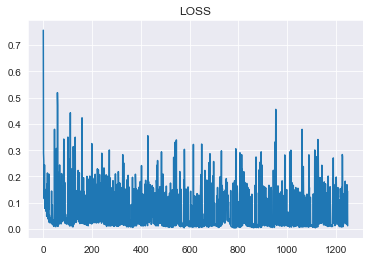

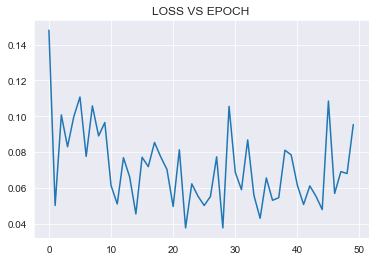

In [6]:
plt.plot(loss_history[0])
plt.title('LOSS')
plt.show()

plt.plot(loss_history[1])
plt.title('LOSS VS EPOCH')
plt.show()

#### 2.Plotting Accuracy vs Epoch<a class="anchor" id="5.2"></a>

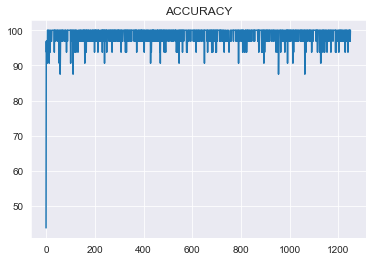

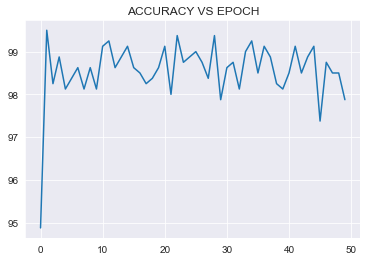

In [7]:
plt.plot(accuracy_history[0])
plt.title('ACCURACY')
plt.show()

plt.plot(accuracy_history[1])
plt.title('ACCURACY VS EPOCH')
plt.show()

### 6.Testing<a class="anchor" id="6"></a>

In [8]:
margin = 0
test_path = 'data/test/'

classes = []
target_img = []
reference_img = []
target_cropped_img = []
reference_cropped_img = []

mtcnn = MTCNN(image_size=128 , margin = margin)
unloader = T.Compose([T.ToPILImage()])
loader = T.Compose([T.ToTensor()])

for i in os.listdir(test_path):
    if os.path.isdir(test_path+i):
        classes.append(i)      
    else:
        target_img.append(Image.open(test_path+i))
        
for i in classes:
    reference_img.append(Image.open(test_path+i+'/'+os.listdir(test_path + i)[0]))
    


#### 1.Reference Images<a class="anchor" id="6.1"></a>

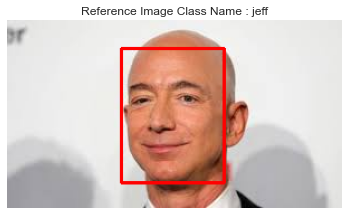

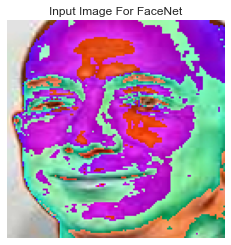

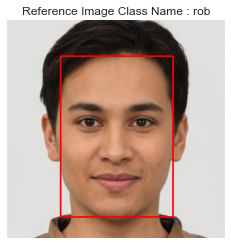

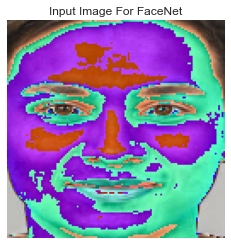

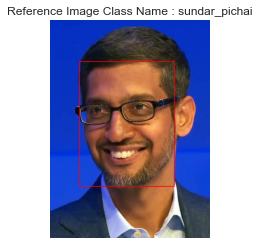

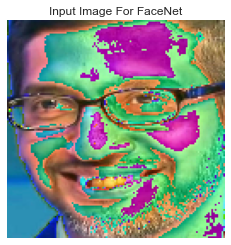

In [9]:
for i in range(len(reference_img)):
    boxes, probs, points = mtcnn.detect(reference_img[i], landmarks=True)

    img = np.array(reference_img[i])
    boxes = (np.array(boxes[0])*1).astype(int)
    boxes[0:2] = boxes[0:2] - int(margin/2)
    boxes[2:] = boxes[2:] + int(margin/2)
    input_img = img[boxes[1]:boxes[3]+1,boxes[0]:boxes[2]+1].copy()
    input_img = cv2.resize(input_img, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
    input_img = loader((input_img - 127.5) / 128.0).type(torch.FloatTensor)
    reference_cropped_img.append(input_img)
    
    img = cv2.rectangle(img, (boxes[0],boxes[1]), (boxes[2],boxes[3]), (255, 0, 0) , 2)
    plt.imshow(img)
    plt.title(f'Reference Image Class Name : {classes[i]}')
    plt.grid(b=None)
    plt.axis('off')
    plt.show()
    
    plt.imshow(unloader(input_img))
    plt.title('Input Image For FaceNet')
    plt.grid(b=None)
    plt.axis('off')
    plt.show()
    

#### 2.Target Images<a class="anchor" id="6.2"></a>

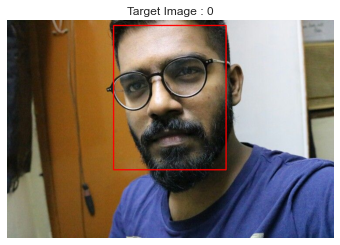

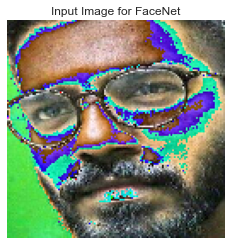

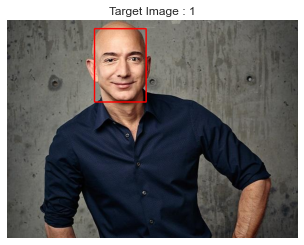

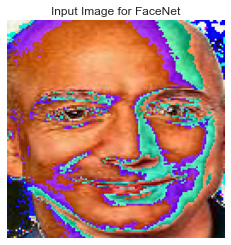

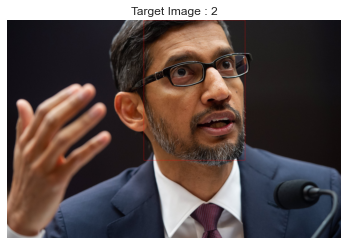

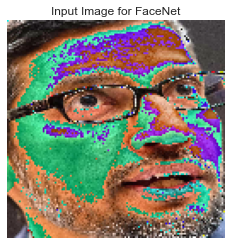

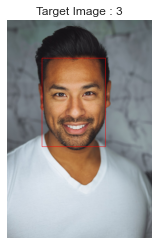

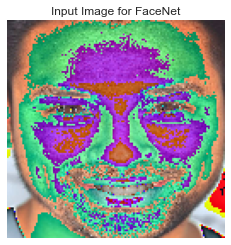

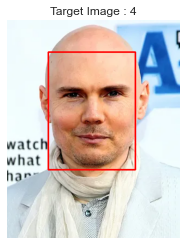

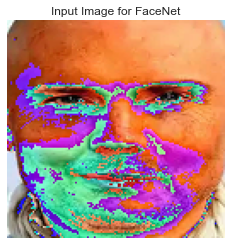

In [10]:
for i in range(len(target_img)):
    boxes, probs, points = mtcnn.detect(target_img[i], landmarks=True)

    img = np.array(target_img[i])
    boxes = (np.array(boxes[0])*1).astype(int)
    boxes[0:2] = boxes[0:2] - int(margin/2)
    boxes[2:] = boxes[2:] + int(margin/2)
    input_img = img[boxes[1]:boxes[3]+1,boxes[0]:boxes[2]+1].copy()
    input_img = cv2.resize(input_img, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
    input_img = loader((input_img - 127.5) / 128.0).type(torch.FloatTensor)
    target_cropped_img.append(input_img)
    
    img = cv2.rectangle(img, (boxes[0],boxes[1]), (boxes[2],boxes[3]), (255, 0, 0) , 2)
    plt.imshow(img)
    plt.title(f'Target Image : {i}')
    plt.grid(b=None)
    plt.axis('off')
    plt.show()
    
    plt.imshow(unloader(input_img))
    plt.title('Input Image for FaceNet')
    plt.grid(b=None)
    plt.axis('off')
    plt.show()
    

#### 3.Predictions<a class="anchor" id="6.3"></a>

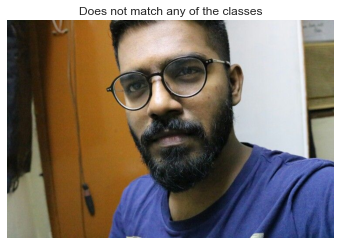

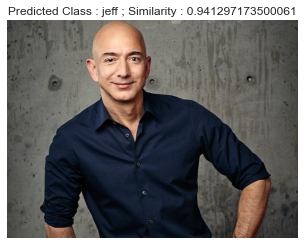

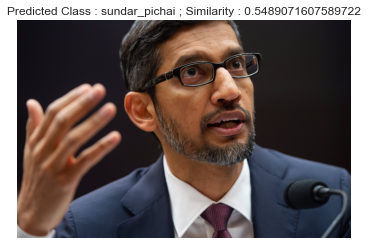

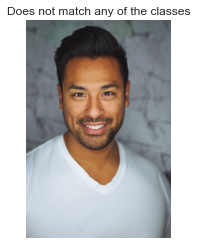

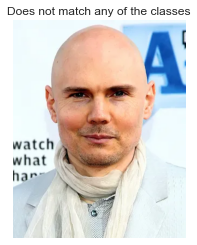

In [11]:
resnet = InceptionResnetV1(pretrained='vggface2').to(device).eval()
embeddings = resnet(input_img.unsqueeze(0).to(device)).reshape((1,1,512))
THRESHOLD = 0.4

model.eval()
for i in range(len(target_img)):
    similarity = [] 
    target_embeddings = resnet(target_cropped_img[i].unsqueeze(0).to(device)).reshape((1,1,512))
    
    for j in reference_cropped_img:
        j_embeddings = resnet(j.unsqueeze(0).to(device)).reshape((1,1,512))
        similarity.append(model(target_embeddings, j_embeddings).item())
    
    max_similarity = max(similarity)
    if max_similarity >= THRESHOLD:
        predicted_class = classes[similarity.index(max_similarity)]
    
        plt.imshow(target_img[i])
        plt.title(f'Predicted Class : {predicted_class} ; Similarity : {max_similarity}')
        plt.grid(b=None)
        plt.axis('off')
        plt.show()
        
    else:
        plt.imshow(target_img[i])
        plt.title('Does not match any of the classes')
        plt.grid(b=None)
        plt.axis('off')
        plt.show()


